## Pf6 heterozygous calls

My Drive/GitHub/gtg/Pf6_het_calls_230317.ipynb

This code examines the frequency distribution of heterozgous genotype calls in the [Pf6 dataset](https://www.malariagen.net/sites/default/files/File8_Pf_6_README_20191010_0.txt).  It uses downloaded Zarr data and sample metadata that are stored locally on ThinkPad_2022 in 'C:\\Users\\dkwia\\Data\\Pf6\\'. 

* extract lists of samples (n = 7,113) and variant properties (n = 6,051,696) as numpy arrays

* select variants that are high-quality biallelic coding SNPs (n = 502,221)

* extract allele depth for high-quality SNPs from Zarr into `allele_depth_1.npy`.  We do this in chunks of 10,000 variants at a time to avoid memory problems

* extract sample metadata from samples.txt into a dataframe

* read info about sample QC into an array

* extract allele depth for high-quality SNPs and high-quality samples (n = 5,970) into `allele_depth_2.npy` 

* calculate within-host heterozygosity for each SNP in each sample and save to `wiho_het.npy`

* calculate mean within-host heterozygosity for each SNP across all samples and save to a list called wiho_het_per_snp

* using wiho_het_per_snp, create `snp_filter` to filter out potential hyperhet SNPs

* create `sample_filter` to select samples from a particular geographical region

* translate mean within-host heterozygosity per sample into $\pi_W$ for each sample, allowing for the number of SNPs ascertained and the size of coding regions

* plot a histogram of nucleotide diversity per sample

* view the histogram for different filter cutoffs for hyperhet SNPs and for different regions e.g. West Africa vs Southeast Asia

*Note to self.  We could compute maf for each SNP using callset/variants/AC (count of nonref alleles) and callset/variants/AN (total number of called alleles) but this is based on diploid genotyping which may not pick up low but significant hyperheterozygosity within a sample.*

In [1]:
import zarr
import numpy as np
import pandas as pd
import json
import math
import time
import matplotlib.pyplot as plt
import statistics as stat

In [2]:
data_path = 'C:\\Users\\dkwia\\Data\\Pf6\\'

callset = zarr.open_group(data_path + 'Pf_6.zarr', mode = 'r')
callset.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='calldata', nodes=(Node(disabled=Tru…

# Run

## Copy samples and variant properties into arrays
* 7,113 samples 
* 6,051,696 variants

## Select high-quality biallelic coding SNPs
* high quality means 'filter_pass == True' & 'vqslod > 3'
* 502,221 variants meet criteria
* `select` is a mask for an array of 6,051,696 variants

In [3]:
samples = callset['samples'][:]

filter_pass = callset['variants/FILTER_PASS'][:]
vqslod = callset['variants/VQSLOD'][:]
snp = callset['variants/is_snp'][:]
coding = callset['variants/CDS'][:]
numalt = callset['variants/numalt'][:]
effect = callset['variants/SNPEFF_EFFECT'][:]

# select biallelic synonymous coding SNPs and create a mask
select = (filter_pass == True) & (snp == True) & (numalt == 1) & (coding == True) & (vqslod > 3)

# & (effect == 'SYNONYMOUS_CODING') 

selected_snps = np.count_nonzero(select == True)

total_variants = len(snp)
total_samples = len(samples)

print('There are {0:d} variants and {1:d} selected SNPs in {2:d} samples.'.
      format(total_variants, selected_snps, total_samples))

There are 6051696 variants and 502221 selected SNPs in 7113 samples.


#### Save allele depths for selected SNPs in `allele_depth_1.npy`
* Use the `select` mask created above to pull out selected SNPs
* Copy allele depths for selected SNPs from 'calldata/AD' into `selected_gt_1`
  * calldata/AD allows for multiallelic loci by containing allele depth for up to 7 variant alleles
  * Since we focus on biallelic SNPs we include only the first two alleles from calldata/AD
* This file is 14GB

In [ ]:
# We extract allele depth data for selected SNPs into a numpy array.
# We do this in chunks of 10000 variants at a time to avoid memory problems.
# This step can be omitted by retrieving saved data in the next section.

ad = callset['calldata/AD']

allele_depth_1 = 9 * np.ones((selected_snps, total_samples, 2), dtype=np.int16)

selected_snp_id = 0

chunk_size = 10000

for i in range(int(total_variants / chunk_size)):
    
    start_time = time.time()
    
    chunk = ad[(i * chunk_size) : ((i + 1) * chunk_size), :, :2]
    
    chunk_snps = 0

    for j in range(chunk_size):
        
        variant_id = i * chunk_size + j
    
        if select[variant_id] == True:
            
            allele_depth_1[selected_snp_id, :, :] = chunk[j, :, :]
            
            selected_snp_id += 1
            
            chunk_snps += 1
               
    chunk_time = time.time() - start_time
        
    print('chunk {0:d} had {1:d} SNPs and took {2:.2f} seconds'.
          format(i, chunk_snps, chunk_time))

start_time = time.time()

chunk = ad[(i * chunk_size) :, :, :]

chunk_snps = 0

for j in range(total_variants % chunk_size):
    
    if select[(i + 1) * chunk_size + j] == True:
            
        allele_depth_1[selected_snp_id, :, :] = chunk[j, :, :]
        
        selected_snp_id += 1
            
        chunk_snps += 1
               
    chunk_time = time.time() - start_time
        
print('chunk {0:d} had {1:d} SNPs and took {2:.1f} seconds'.
     format(i, chunk_snps, chunk_time))

total_snps = selected_snp_id

print('total of {0:d} selected snps'.format(total_snps))

np.save(data_path + '221221_selected_gt_1', allele_depth_1)

# Run

#### Select samples and list region of each selected sample
* 'Population' in Pf6_samples.txt gives: 'SAM'=South America, 'WAF'=West Africa, 'CAF'=Central Africa, 'EAF'=East African, 'SAS'=South Asia, 'WSEA'=Western SE Asia, 'ESEA'=Eastern SE Asia, 'OCE'=Oceania

In [10]:
df = pd.read_table(data_path + 'samples.txt')

select_sample = np.array(df['QC pass'])

selected_samples = np.count_nonzero(select_sample == True)

print('There are', str(selected_samples), 'selected samples that passed QC')

region = []

for i in range(total_samples):
    
    if select_sample[i] == True:
        
        region.append(df['Population'][i])
        
with open(data_path + "230316_region", "w") as fp:
    json.dump(region, fp)

There are 5970 selected samples that passed QC


#### Copy allele depth for QC pass samples from `allele_depth_1` into `allele_depth_2`
* 'QC pass' field in samples.txt gives True/False
* Save as .npy file (~11.7GB) so that this step only has to be run once

In [35]:
allele_depth_1 = np.load(data_path + '221221_selected_gt_1.npy')

allele_depth_2 = 9 * np.ones((selected_snps, selected_samples, 2), dtype=np.int16)

for i in range(total_samples):
    
    if select_sample[i] == True:
        
        allele_depth_2[:, selected_sample_id, :] = allele_depth_1[:, i, :]
        
np.save(data_path + '221221_selected_gt_2', allele_depth_2)

There are 5970 selected samples that passed QC


#### Calculate within-host heterozygosity for each SNP and save as `wiho_het.npy`
* if ref_allele + alt_allele == 1 then write het = 0.
* this file is 23.5GB because dtype=float

In [5]:
allele_depth_2 = np.load(data_path + '221221_selected_gt_2.npy') #, mmap_mode = 'r')

selected_samples = len(allele_depth_2[0, :, 0])

wiho_het = np.ones((selected_snps, selected_samples), dtype=float)

for i in range(selected_snps):
    for j in range(selected_samples):
        
        ref_allele = allele_depth_2[i, j, 0]
        alt_allele = allele_depth_2[i, j, 1]
        denominator = ref_allele + alt_allele
        if denominator != 0:
            allele_freq = alt_allele / denominator
            het = 2 * allele_freq * (1 - allele_freq)
        else:
            het = 0 # this is a hack
            
        wiho_het[i, j] = het

    if i % 100 == 0:
        print(i)
        
np.save(data_path + '230113_wiho_het.npy', wiho_het)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

133000
133100
133200
133300
133400
133500
133600
133700
133800
133900
134000
134100
134200
134300
134400
134500
134600
134700
134800
134900
135000
135100
135200
135300
135400
135500
135600
135700
135800
135900
136000
136100
136200
136300
136400
136500
136600
136700
136800
136900
137000
137100
137200
137300
137400
137500
137600
137700
137800
137900
138000
138100
138200
138300
138400
138500
138600
138700
138800
138900
139000
139100
139200
139300
139400
139500
139600
139700
139800
139900
140000
140100
140200
140300
140400
140500
140600
140700
140800
140900
141000
141100
141200
141300
141400
141500
141600
141700
141800
141900
142000
142100
142200
142300
142400
142500
142600
142700
142800
142900
143000
143100
143200
143300
143400
143500
143600
143700
143800
143900
144000
144100
144200
144300
144400
144500
144600
144700
144800
144900
145000
145100
145200
145300
145400
145500
145600
145700
145800
145900
146000
146100
146200
146300
146400
146500
146600
146700
146800
146900
147000
147100
147200

250100
250200
250300
250400
250500
250600
250700
250800
250900
251000
251100
251200
251300
251400
251500
251600
251700
251800
251900
252000
252100
252200
252300
252400
252500
252600
252700
252800
252900
253000
253100
253200
253300
253400
253500
253600
253700
253800
253900
254000
254100
254200
254300
254400
254500
254600
254700
254800
254900
255000
255100
255200
255300
255400
255500
255600
255700
255800
255900
256000
256100
256200
256300
256400
256500
256600
256700
256800
256900
257000
257100
257200
257300
257400
257500
257600
257700
257800
257900
258000
258100
258200
258300
258400
258500
258600
258700
258800
258900
259000
259100
259200
259300
259400
259500
259600
259700
259800
259900
260000
260100
260200
260300
260400
260500
260600
260700
260800
260900
261000
261100
261200
261300
261400
261500
261600
261700
261800
261900
262000
262100
262200
262300
262400
262500
262600
262700
262800
262900
263000
263100
263200
263300
263400
263500
263600
263700
263800
263900
264000
264100
264200
264300

367200
367300
367400
367500
367600
367700
367800
367900
368000
368100
368200
368300
368400
368500
368600
368700
368800
368900
369000
369100
369200
369300
369400
369500
369600
369700
369800
369900
370000
370100
370200
370300
370400
370500
370600
370700
370800
370900
371000
371100
371200
371300
371400
371500
371600
371700
371800
371900
372000
372100
372200
372300
372400
372500
372600
372700
372800
372900
373000
373100
373200
373300
373400
373500
373600
373700
373800
373900
374000
374100
374200
374300
374400
374500
374600
374700
374800
374900
375000
375100
375200
375300
375400
375500
375600
375700
375800
375900
376000
376100
376200
376300
376400
376500
376600
376700
376800
376900
377000
377100
377200
377300
377400
377500
377600
377700
377800
377900
378000
378100
378200
378300
378400
378500
378600
378700
378800
378900
379000
379100
379200
379300
379400
379500
379600
379700
379800
379900
380000
380100
380200
380300
380400
380500
380600
380700
380800
380900
381000
381100
381200
381300
381400

484300
484400
484500
484600
484700
484800
484900
485000
485100
485200
485300
485400
485500
485600
485700
485800
485900
486000
486100
486200
486300
486400
486500
486600
486700
486800
486900
487000
487100
487200
487300
487400
487500
487600
487700
487800
487900
488000
488100
488200
488300
488400
488500
488600
488700
488800
488900
489000
489100
489200
489300
489400
489500
489600
489700
489800
489900
490000
490100
490200
490300
490400
490500
490600
490700
490800
490900
491000
491100
491200
491300
491400
491500
491600
491700
491800
491900
492000
492100
492200
492300
492400
492500
492600
492700
492800
492900
493000
493100
493200
493300
493400
493500
493600
493700
493800
493900
494000
494100
494200
494300
494400
494500
494600
494700
494800
494900
495000
495100
495200
495300
495400
495500
495600
495700
495800
495900
496000
496100
496200
496300
496400
496500
496600
496700
496800
496900
497000
497100
497200
497300
497400
497500
497600
497700
497800
497900
498000
498100
498200
498300
498400
498500

#### Calculate mean within-host heterozygosity for each SNP

In [7]:
wiho_het = np.load(data_path + '230113_wiho_het.npy', mmap_mode = 'r')

het_per_snp = []

for i in range(selected_snps):
    
    x = np.mean(wiho_het[i, :])
    
    het_per_snp.append(x)
    
with open(data_path + "230317_het_per_snp", "w") as filepath:
    json.dump(het_per_snp, filepath)        

# Run

#### Create `snp_filter` to filter out possible hyperhets
* Here we use het >= 0.02 as our criterion for exclusion 

In [8]:
with open(data_path + "230317_het_per_snp", "r") as fp:
    het_per_snp = json.load(fp)

snp_filter = []

for i in range(selected_snps):
    
    if het_per_snp[i] < 0.02:
        
        snp_filter.append(True)
    
    else:
        snp_filter.append(False)
        
filtered_snps = snp_filter.count(True)
        
print('This includes', str(filtered_snps), 'SNPs')

This includes 496459 SNPs


# Run

#### Create `sample_filter` to select a particular geographical region
* 'SAM'=South America, 'WAF'=West Africa, 'CAF'=Central Africa, 'EAF'=East African, 'SAS'=South Asia, 'WSEA'=Western SE Asia, 'ESEA'=Eastern SE Asia, 'OCE'=Oceania

In [126]:
with open(data_path + "230316_region", "r") as fp:
    region = json.load(fp)

sample_filter = []

for i in range(selected_samples):
    
    if region[i] == "WSEA" or region[i] == "ESEA":
        
        sample_filter.append(True)
        
    else:
        
        sample_filter.append(False)
        
filtered_samples = sample_filter.count(True)
    
print('This includes', str(filtered_samples), 'samples')

This includes 2341 samples


# Run

#### Calculate mean heterozygosity per sample after filtering samples and SNPs
* Creates a list of het values, one for each selected & filtered sample 
* This is the mean het for selected & filtered SNPs and not for all nucleotide positions

In [118]:
wiho_het = np.load(data_path + '230113_wiho_het.npy', mmap_mode = 'r')

het_per_sample = []

for i in range(selected_samples):
    
    if sample_filter[i] == True:

        het = []
    
        for j in range(selected_snps):
    
            if snp_filter[j] == True: 
            
                het.append(wiho_het[j, i])
    
        y = stat.mean(het)
    
        het_per_sample.append(y)
    
    if i % 1000 == 0:
        
        print(i)
        
with open(data_path + "230316_het_per_sample_SEA", "w") as filepath:
    json.dump(het_per_sample, filepath)

0
1000
2000
3000
4000
5000


#### Plot histogram of within-host nucleotide diversity

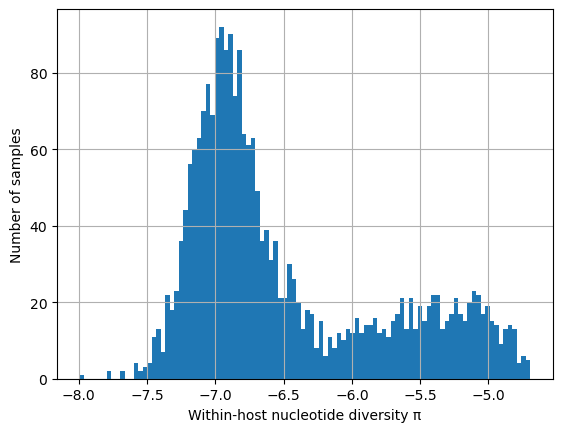

In [119]:
# Southeast Asia - only SNPs with maf < 0.01 

with open(data_path + "230316_het_per_sample_SEA", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

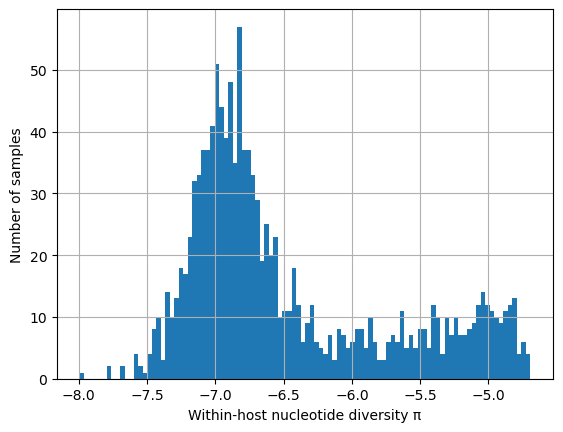

In [110]:
# Eastern Southeast Asia - only SNPs with maf < 0.01 

with open(data_path + "230316_het_per_sample_ESEA", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

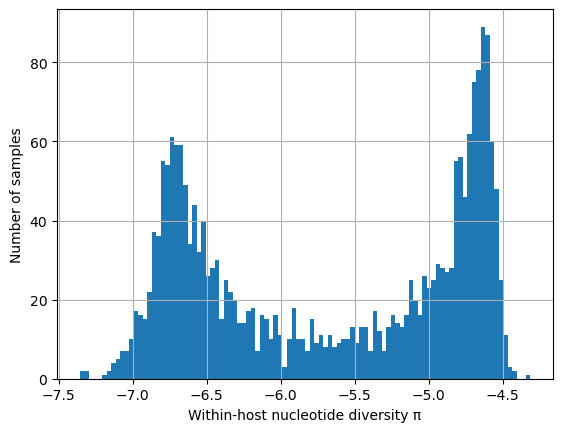

In [103]:
# West Africa - only SNPs with maf < 0.1 

with open(data_path + "230316_het_per_sample_WAF", "r") as filepath:
    het_per_sample = json.load(filepath)
    
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = filtered_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()

-4.772849038534566


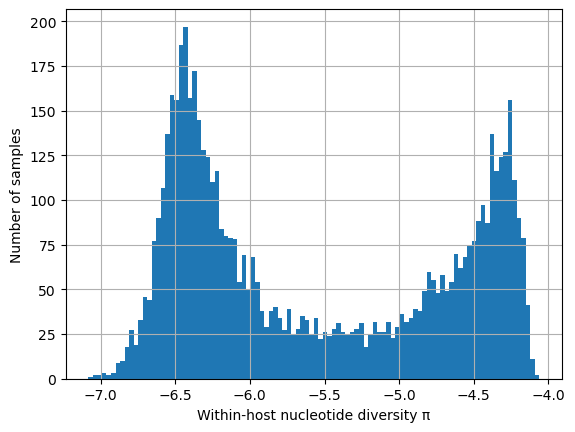

In [9]:
with open(data_path + "230116_het_per_sample_02", "r") as filepath:
    het_per_sample = json.load(filepath)
    
selected_snps = 494829 # this is <0.01 maf, total is 502221
coding_positions = 12028350 # from Gardner et al 2002

convert_het_to_pi = selected_snps / coding_positions

het_per_sample_nonzero = [convert_het_to_pi * x for x in het_per_sample if x != 0]
log_het_per_sample = [math.log(x, 10) for x in het_per_sample_nonzero]
print(stat.mode(log_het_per_sample))
plt.hist(log_het_per_sample, bins = 100)
plt.xlabel('Within-host nucleotide diversity \u03C0')
plt.ylabel('Number of samples')
plt.grid()
plt.show()
